
## Table of Contents
1. [Introduction](#Introduction)
2. [Imports and Setup](#Imports-and-Setup)
3. [Function Definitions](#Function-Definitions)
4. [Processing](#Processing)
5. [Results](#Results)


## Introduction

# Modified Code for HW3 Q3
This notebook processes images from the specified directory structure and uses GTSAM for optimization.


## Imports and Setup

In [1]:
#!/usr/bin/env python3
import os
from matplotlib import pyplot as plt
import cv2
from hw3_q_1 import ImageProcessor
from hw3_q_3 import GTSAMOptimizer
import gtsam
import numpy as np

## Function Definitions

In [2]:
def get_image_pairs(folder_path):
    all_files = os.listdir(folder_path)
    tif_files = sorted(
        [f for f in all_files if f.endswith(".tif")], key=lambda x: int(x.split(".")[0])
    )
    image_numbers = [int(f.split(".")[0]) for f in tif_files]

    image_processor = ImageProcessor()
    image_list = []
    for file in tif_files:
        img = cv2.imread("{}/{}".format(folder_path, file), cv2.IMREAD_GRAYSCALE)
        img = image_processor.robust_normalizer(img)
        image_list.append(img)

    sequential_pairs = []
    non_sequential_pairs = []
    for i in range(len(image_numbers)):
        for j in range(i + 1, len(image_numbers)):
            pair = (image_numbers[i], image_numbers[j])
            if j == i + 1:
                sequential_pairs.append(pair)
            else:
                non_sequential_pairs.append(pair)

    return sequential_pairs, non_sequential_pairs, image_list

def process_image_pairs(pairs, images, is_sequential=True):
    image_processor = ImageProcessor()
    successful_pairs = {}
    homographies = []
    
    for pair in pairs:
        print("Processed Image Pair:", pair)

        keypoints1, keypoints2, matches = image_processor.detect_and_match_features(images[pair[0] - 1], images[pair[1] - 1])
        H, mask = image_processor.compute_homography_and_filter_matches(keypoints1, keypoints2, matches)
        
        if H is not None:
            print("Homography:", H)
            successful_pairs[pair] = {"H": H}
            homographies.append(H)

    print("Successful Pairs:", successful_pairs.keys())
    return successful_pairs, homographies

def process_columns(base_path, all_images, optimizer):
    sequential_pairs, _, images = get_image_pairs(base_path)
    all_images += images

    successful_pairs, _ = process_image_pairs(sequential_pairs, all_images)

    # Add factors and initial estimates to GTSAM optimizer
    for pair, data in successful_pairs.items():
        H = data["H"]
        # Convert homography to pose (for simplicity, just taking translational components)
        motion = {"x": H[0, 2], "y": H[1, 2], "theta": np.arctan2(H[1, 0] - H[0, 1], H[0, 0] + H[1, 1])}
        optimizer.add_in_between_factors({f"pose_{pair[0]}pose_{pair[1]}": motion})
        
        # Add initial estimates for the poses
        optimizer.add_initial_estimate(f"pose_{pair[0]}", gtsam.Pose2(0, 0, 0))
        # Introduce perturbation for the next pose based on the motion from the homography
        optimizer.add_initial_estimate(f"pose_{pair[1]}", gtsam.Pose2(motion['x']*0.1, motion['y']*0.1, 0))

    return all_images


def get_cross_column_pairs(column1_path, column2_path):
    # Get images from column1
    all_files_column1 = os.listdir(column1_path)
    tif_files_column1 = sorted(
        [f for f in all_files_column1 if f.endswith(".tif")], 
        key=lambda x: int(x.split(".")[0])
    )
    image_numbers_c1 = [int(f.split(".")[0]) for f in tif_files_column1]

    # Get images from column2
    all_files_column2 = os.listdir(column2_path)
    tif_files_column2 = sorted(
        [f for f in all_files_column2 if f.endswith(".tif")], 
        key=lambda x: int(x.split(".")[0])
    )
    image_numbers_c2 = [int(f.split(".")[0]) for f in tif_files_column2]

    # Generate cross column pairs
    pairs = [(x, y) for x in image_numbers_c1 for y in image_numbers_c2]

    return pairs

def compute_absolute_poses(optimizer, motions, images):
    poses = {}
    current_pose = gtsam.Pose2(0, 0, 0)  # Initial pose
    poses["pose_1"] = {'x': current_pose.x(), 'y': current_pose.y(), 'theta': current_pose.theta()}
    
    for i in range(1, len(images)):
        relative_motion = motions.get(f"pose_{i}pose_{i+1}", None)
        if relative_motion:
            relative_pose = gtsam.Pose2(relative_motion['x'], relative_motion['y'], relative_motion['theta'])
            current_pose = current_pose.compose(relative_pose)
            poses[f"pose_{i+1}"] = {'x': current_pose.x(), 'y': current_pose.y(), 'theta': current_pose.theta()}
    
    return poses


def process_cross_columns(path1, path2, all_images, optimizer):
    cross_column_pairs = get_cross_column_pairs(path1, path2)
    successful_pairs, _ = process_image_pairs(cross_column_pairs, all_images, is_sequential=False)

    # Add factors and initial estimates to GTSAM optimizer
    for pair, data in successful_pairs.items():
        H = data["H"]
        # Convert homography to pose (for simplicity, just taking translational components)
        motion = {"x": H[0, 2], "y": H[1, 2], "theta": np.arctan2(H[1, 0] - H[0, 1], H[0, 0] + H[1, 1])}
        optimizer.add_loop_closure_factors({f"pose_{pair[0]}pose_{pair[1]}": motion})

        # Add initial estimates for the poses
        if abs(pair[1] - pair[0]) == 1:  # Check if they are sequential
            optimizer.add_initial_estimate(f"pose_{pair[0]}", gtsam.Pose2(0, 0, 0))
            optimizer.add_initial_estimate(f"pose_{pair[1]}", gtsam.Pose2(motion['x']*0.1, motion['y']*0.1, np.arctan2(H[1, 0] - H[0, 1], H[0, 0] + H[1, 1])))
        else:
            optimizer.add_initial_estimate(f"pose_{pair[0]}", gtsam.Pose2(0, 0, 0))  # Using identity as initial guess
            optimizer.add_initial_estimate(f"pose_{pair[1]}", gtsam.Pose2(0, 0, 0))


## Processing

Processed Image Pair: (1, 2)
Homography: [[ 9.78656848e-01 -6.07773599e-02  2.64522479e+01]
 [ 1.35990602e-02  9.46810520e-01 -1.15924566e+02]
 [ 2.34894443e-05 -1.67700723e-04  1.00000000e+00]]
Processed Image Pair: (2, 3)
Homography: [[ 9.62277545e-01 -7.25805784e-02  2.60862166e+01]
 [ 1.70067779e-02  9.90347260e-01 -1.32025355e+02]
 [-1.15711520e-05 -1.60770453e-04  1.00000000e+00]]
Processed Image Pair: (3, 4)
Homography: [[ 9.94927985e-01 -4.33916901e-02  4.13333969e+01]
 [ 2.40494573e-02  9.71850623e-01 -1.24356586e+02]
 [ 4.13748493e-05 -1.34060669e-04  1.00000000e+00]]
Processed Image Pair: (4, 5)
Homography: [[ 9.73351169e-01 -3.63908659e-02  2.44008734e+01]
 [ 1.38509618e-02  9.52641996e-01 -1.09257309e+02]
 [ 2.76446884e-06 -1.32547272e-04  1.00000000e+00]]
Processed Image Pair: (5, 6)
Homography: [[ 1.00060272e+00  1.32830166e-03  3.51905531e+01]
 [ 1.53235209e-02  8.53852819e-01 -1.83494276e+02]
 [ 1.53741973e-05 -5.28988127e-05  1.00000000e+00]]
Processed Image Pair: (6,

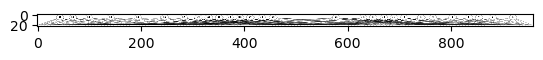

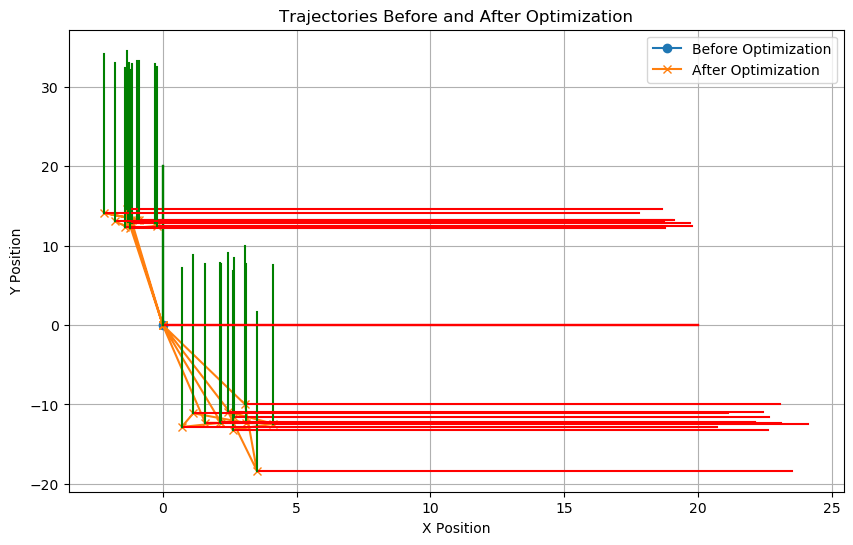

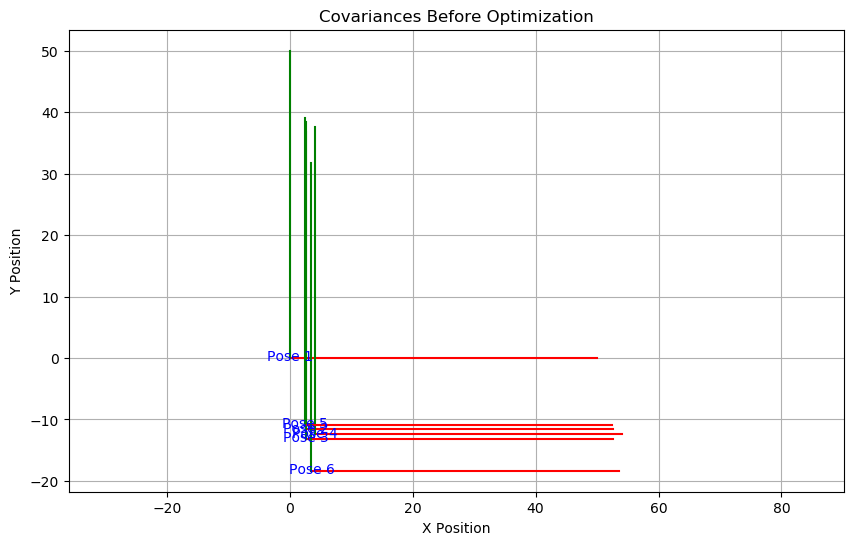

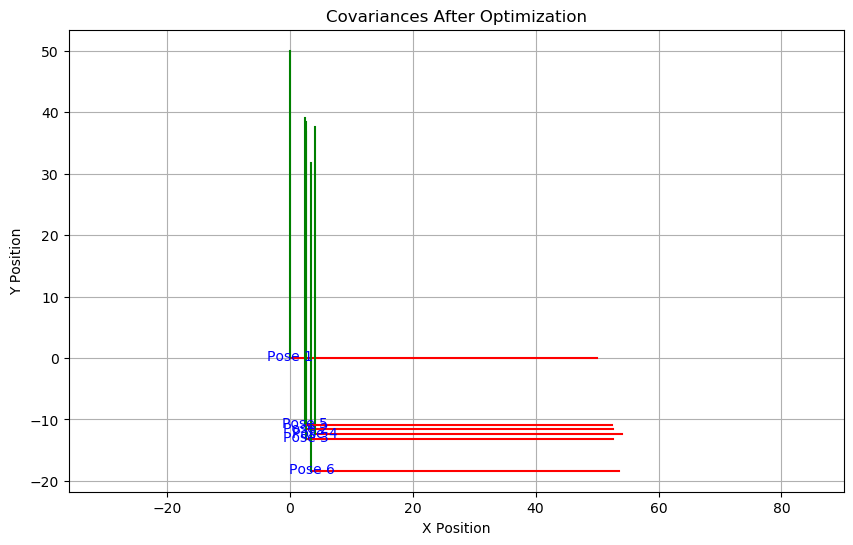

In [3]:
optimizer = GTSAMOptimizer()
processor = ImageProcessor()
all_29_images = []

# Process columns
for column in ["c1", "c2", "c3", "c4"]:
    base_path = f"/home/tides/Desktop/EECE7150/hw3/29images/{column}"
    all_29_images = process_columns(base_path, all_29_images, optimizer)
    
optimizer.add_prior_factor() 
# Process cross columns
base_path = "/home/tides/Desktop/EECE7150/hw3/29images"
process_cross_columns(f"{base_path}/c1", f"{base_path}/c2", all_29_images, optimizer)
process_cross_columns(f"{base_path}/c2", f"{base_path}/c3", all_29_images, optimizer)
process_cross_columns(f"{base_path}/c3", f"{base_path}/c4", all_29_images, optimizer)

optimizer.optimize()

# Extract the poses and plot before and after optimization
absolute_poses_before = compute_absolute_poses(optimizer, {}, all_29_images)  # Initial poses without optimization
absolute_poses_after = optimizer.extract_optimized_poses()  # Extract poses after optimization
optimizer.print_marginal_covariances()
optimizer.plot_factor_graph()
# Plot the trajectories before and after optimization
optimizer.plot_trajectories(absolute_poses_before, absolute_poses_after, title="Trajectories Before and After Optimization")

# Plot covariances before and after optimization
optimizer.plot_covariances(optimizer.initial_estimates, "Covariances Before Optimization")
optimizer.plot_covariances(optimizer.result, "Covariances After Optimization")

# Show the results
plt.show()


## Results

In [4]:
optimizer.result.print()

Values with 28 values:
Value 1: (gtsam::Pose2)
(0, 0, 0)

Value 2: (gtsam::Pose2)
(2.64522, -11.5925, 0)

Value 3: (gtsam::Pose2)
(2.60862, -13.2025, 0)

Value 4: (gtsam::Pose2)
(4.13334, -12.4357, 0)

Value 5: (gtsam::Pose2)
(2.44009, -10.9257, 0)

Value 6: (gtsam::Pose2)
(3.51906, -18.3494, 0)

Value 7: (gtsam::Pose2)
(3.07227, -9.98738, 0)

Value 8: (gtsam::Pose2)
(0, 0, 0)

Value 9: (gtsam::Pose2)
(-1.14343, 12.8446, 0)

Value 10: (gtsam::Pose2)
(-1.31933, 12.9341, 0)

Value 11: (gtsam::Pose2)
(-0.950569, 13.2582, 0)

Value 12: (gtsam::Pose2)
(-1.39533, 12.3655, 0)

Value 13: (gtsam::Pose2)
(-1.3557, 14.5593, 0)

Value 14: (gtsam::Pose2)
(0, 0, 0)

Value 15: (gtsam::Pose2)
(1.58696, -12.3183, 0)

Value 16: (gtsam::Pose2)
(3.1038, -12.317, 0)

Value 17: (gtsam::Pose2)
(1.1391, -11.1123, 0)

Value 18: (gtsam::Pose2)
(0.705943, -12.8433, 0)

Value 19: (gtsam::Pose2)
(2.18563, -12.3068, 0)

Value 20: (gtsam::Pose2)
(2.15422, -12.1854, 0)

Value 21: (gtsam::Pose2)
(0, 0, 0)

Value 22: (